# Women's World Cup 2024!

I'm starting from code that I made for an analysis of Men's Euro's 2024 Cup, and working from there. I've changed some of the info to clean up the flow as well as added something I heard Julie Foudy talking about in the last USA match against Germany--the time between matches was ridiculous in terms of turnaround for the teams. Also, that the teams were having to travel so much. So I've included some analysis of time between games for teams as well as how far they had to travel. Should be interesting!!

In [21]:
from datetime import date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import absolute
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer 

#Start loading the data
file_path = 'Womens Football Olympics 2024 - Match_Info.csv'  
df_match_info = pd.read_csv(file_path)


In [45]:
#Need all the sheets!

df_rankings = pd.read_csv('Womens Football Olympics 2024 - FIFA_Rankings.csv')
df_minutes = pd.read_csv('Womens Football Olympics 2024 - Minutes.csv')
df_results = pd.read_csv('Womens Football Olympics 2024 - Results.csv')

In [25]:
#The results is the main df that I want to join all other dataframes to
df_results

,Match,Country,Total_Goal,Result
0,1,France,3,W
1,1,Columbia,2,L
2,2,Canada,2,W
3,2,New_Zealand,1,L
4,3,USA,3,W
5,3,Zambia,0,L
6,4,Germany,3,W
7,4,Australia,0,L
8,5,Spain,2,W
9,5,Japan,1,L


In [34]:
goals = df_results.groupby(['Country']).sum(['Total_Goal'])

In [35]:
goals = goals.drop(columns=['Match'])

In [53]:
goals

,Total_Goal
Country,
Australia,7
Brazil,7
Canada,5
Columbia,6
France,6
Germany,8
Japan,6
New_Zealand,2
Nigeria,1


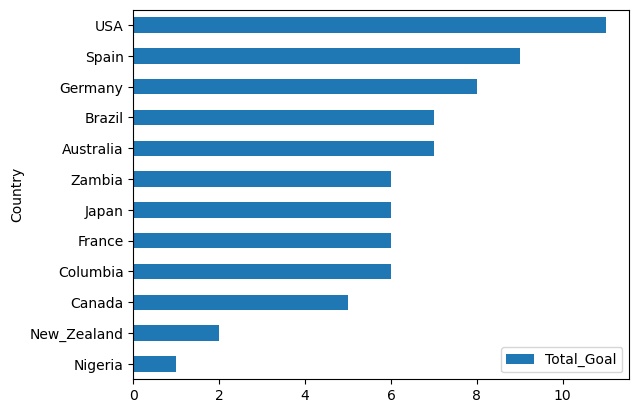

In [59]:
#Here are the goal totals

goals.sort_values('Total_Goal', ascending=True).plot.barh();

In [40]:
df = pd.merge(df_results, df_minutes, how='left', on=['Match','Country'])

In [46]:
df = pd.merge(df, df_rankings, how='left', on='Country')

In [76]:
df = pd.merge(df, df_match_info, how='left', on='Match')

In [77]:
df

,Match,Country,Total_Goal,Result,Goal,Minute,Half,Status,Notes,Rankings,Date,Location
0,1,France,3,W,1.0,6.0,1.0,W,NaN,2,2024-7-25,Lyon
1,1,France,3,W,2.0,18.0,1.0,W,NaN,2,2024-7-25,Lyon
2,1,France,3,W,3.0,42.0,1.0,W,NaN,2,2024-7-25,Lyon
3,1,Columbia,2,L,4.0,54.0,2.0,W,P,22,2024-7-25,Lyon
4,1,Columbia,2,L,5.0,64.0,2.0,W,NaN,22,2024-7-25,Lyon
...,...,...,...,...,...,...,...,...,...,...,...,...
81,23,Brazil,4,W,5.0,91.0,2.0,W,SHST,9,2024-8-6,Marseille
82,23,Spain,2,L,4.0,85.0,2.0,L,OG,1,2024-8-6,Marseille
83,23,Spain,2,L,6.0,102.0,2.0,L,SHST,1,2024-8-6,Marseille
84,24,USA,1,W,1.0,95.0,3.0,W,ET1,5,2024-8-6,Lyon


In [80]:
df.dtypes

Match           int64
Country        object
Total_Goal      int64
Result         object
Goal          float64
Minute        float64
Half          float64
Status         object
Notes          object
Rankings        int64
Date           object
Location       object
dtype: object

In [86]:
df.describe()

,Match,Total_Goal,Goal,Minute,Half,Rankings
count,86.000000,86.000000,72.000000,72.000000,72.000000,86.000000
mean,11.988372,2.418605,2.902778,53.444444,1.555556,13.686047
std,6.876207,1.711313,2.182902,29.638141,0.553831,17.215083
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,7.000000,1.000000,1.000000,25.750000,1.000000,4.000000
50%,10.500000,2.000000,2.000000,51.000000,2.000000,7.000000
75%,17.750000,4.000000,4.000000,78.250000,2.000000,12.000000
max,24.000000,6.000000,11.000000,107.000000,3.000000,64.000000


This is pretty interesting: the average minute a goal was scored was in the 53 minute, pretty soon after half. But, the standard deviation was almost half an hour. The half the goals were scored before or after the 51st minute, so the mean and median are relatively close, but the range is huge. From the first minute to  Makes me want to see when goals were scored! 

In [64]:
goals_by_half=df.groupby(['Country', 'Half']).count()

In [69]:
goals_by_half=goals_by_half.drop(columns=['Match', 'Result', 'Goal', 'Minute', 'Status', 'Notes','Rankings'])

In [68]:
goals_by_half

Match  Total_Goal  Result  Goal  Minute  Status  Notes  \
Country   Half                                                           
Australia 1.0       2           2       2     2       2       2      0   
          2.0       5           5       5     5       5       5      3   
Brazil    1.0       3           3       3     3       3       3      2   
          2.0       4           4       4     4       4       4      1   
Canada    1.0       1           1       1     1       1       1      0   
          2.0       4           4       4     4       4       4      2   
Columbia  1.0       3           3       3     3       3       3      0   
          2.0       3           3       3     3       3       3      1   
France    1.0       5           5       5     5       5       5      0   
          2.0       1           1       1     1       1       1      0   
Germany   1.0       3           3       3     3       3       3      0   
          2.0       5           5       5     5       5       5      1   
Japan     1.0       4           4       4     4       4       4      1   
          2.0       2           2       2     2       2       2      2   
Nigeria   1.0       1           1       1     1       1       1      0   
Spain     1.0       1           1       1     1       1       1      0   
          2.0       8           8       8     8       8       8      4   
USA       1.0       7           7       7     7       7       7      0   
          2.0       2           2       2     2       2       2      0   
          3.0       2           2       2     2       2       2      2   
Zambia    1.0       4           4       4     4       4       4      1   
          2.0       2           2       2     2       2       2      0   

                Rankings  
Country   Half            
Australia 1.0          2  
          2.0          5  
Brazil    1.0          3  
          2.0          4  
Canada    1.0          1  
          2.0          4  
Columbia  1.0          3  
          2.0          3  
France    1.0          5  
          2.0          1  
Germany   1.0          3  
          2.0          5  
Japan     1.0          4  
          2.0          2  
Nigeria   1.0          1  
Spain     1.0          1  
          2.0          8  
USA       1.0          7  
          2.0          2  
          3.0          2  
Zambia    1.0          4  
          2.0          2

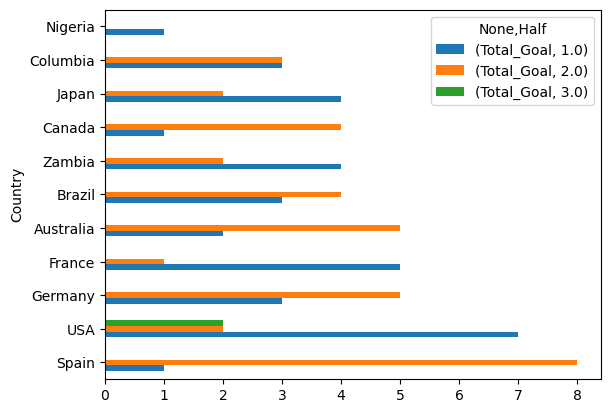

In [75]:
goals_by_half.sort_values('Total_Goal', ascending=False).unstack().plot.barh();

This graph is not beautiful, but it shows that USA outscores every other country in the first half. When they go against Brazil in the final, they will need to capitalize in the first half. 

In [87]:
#Here are the Brazilian Stats
df[df['Country']=='Brazil']

,Match,Country,Total_Goal,Result,Goal,Minute,Half,Status,Notes,Rankings,Date,Location
20,6,Brazil,1,W,1.0,37.0,1.0,W,NaN,9,2024-7-25,Bordeaux
45,12,Brazil,1,L,1.0,56.0,2.0,W,NaN,9,2024-7-28,Paris
61,17,Brazil,0,L,NaN,NaN,NaN,NaN,NaN,9,2024-7-31,Bordeaux
69,19,Brazil,1,W,1.0,82.0,2.0,W,NaN,9,2024-8-3,Nantes
78,23,Brazil,4,W,1.0,6.0,1.0,W,OG,9,2024-8-6,Marseille
79,23,Brazil,4,W,2.0,49.0,1.0,W,FHST,9,2024-8-6,Marseille
80,23,Brazil,4,W,3.0,71.0,2.0,W,NaN,9,2024-8-6,Marseille
81,23,Brazil,4,W,5.0,91.0,2.0,W,SHST,9,2024-8-6,Marseille


In [89]:
#Here are the American
df[df['Country']=='USA']

,Match,Country,Total_Goal,Result,Goal,Minute,Half,Status,Notes,Rankings,Date,Location
8,3,USA,3,W,1.0,17.0,1.0,W,NaN,5,2024-7-25,Nice
9,3,USA,3,W,2.0,24.0,1.0,W,NaN,5,2024-7-25,Nice
10,3,USA,3,W,3.0,25.0,1.0,W,NaN,5,2024-7-25,Nice
27,9,USA,4,W,1.0,10.0,1.0,W,NaN,5,2024-7-28,Marseille
28,9,USA,4,W,3.0,26.0,1.0,W,NaN,5,2024-7-28,Marseille
29,9,USA,4,W,4.0,44.0,1.0,W,NaN,5,2024-7-28,Marseille
30,9,USA,4,W,5.0,89.0,2.0,W,NaN,5,2024-7-28,Marseille
54,15,USA,2,W,1.0,43.0,1.0,W,NaN,5,2024-7-31,Marseille
55,15,USA,2,W,2.0,77.0,2.0,W,NaN,5,2024-7-31,Marseille
70,20,USA,1,W,1.0,107.0,3.0,W,ET1ST,5,2024-8-3,Paris


In [105]:
df[df['Country']=='USA'].describe()

,Match,Total_Goal,Goal,Minute,Half,Rankings
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.0
mean,10.818182,2.818182,2.181818,50.636364,1.545455,5.0
std,6.997402,1.167748,1.401298,34.886309,0.820200,0.0
min,3.000000,1.000000,1.000000,10.000000,1.000000,5.0
25%,6.000000,2.000000,1.000000,24.500000,1.000000,5.0
50%,9.000000,3.000000,2.000000,43.000000,1.000000,5.0
75%,15.000000,4.000000,3.000000,83.000000,2.000000,5.0
max,24.000000,4.000000,5.000000,107.000000,3.000000,5.0


I want to include the opps because I think that will affect the model to know who scored against whom.

In [109]:
df[df['Country']=='Brazil'].describe()

,Match,Total_Goal,Goal,Minute,Half,Rankings
count,8.000000,8.000000,7.000000,7.00000,7.000000,8.0
mean,18.250000,2.375000,2.000000,56.00000,1.571429,9.0
std,6.341473,1.767767,1.527525,28.97125,0.534522,0.0
min,6.000000,0.000000,1.000000,6.00000,1.000000,9.0
25%,15.750000,1.000000,1.000000,43.00000,1.000000,9.0
50%,21.000000,2.500000,1.000000,56.00000,2.000000,9.0
75%,23.000000,4.000000,2.500000,76.50000,2.000000,9.0
max,23.000000,4.000000,5.000000,91.00000,2.000000,9.0


In [108]:
df.head(70)

,Match,Country,Total_Goal,Result,Goal,Minute,Half,Status,Notes,Rankings,Date,Location
0,1,France,3,W,1.0,6.0,1.0,W,NaN,2,2024-7-25,Lyon
1,1,France,3,W,2.0,18.0,1.0,W,NaN,2,2024-7-25,Lyon
2,1,France,3,W,3.0,42.0,1.0,W,NaN,2,2024-7-25,Lyon
3,1,Columbia,2,L,4.0,54.0,2.0,W,P,22,2024-7-25,Lyon
4,1,Columbia,2,L,5.0,64.0,2.0,W,NaN,22,2024-7-25,Lyon
...,...,...,...,...,...,...,...,...,...,...,...,...
65,18,Japan,3,W,2.0,32.0,1.0,W,NaN,7,2024-7-31,Nantes
66,18,Japan,3,W,4.0,50.0,1.0,W,FHST,7,2024-7-31,Nantes
67,18,Nigeria,1,L,3.0,42.0,1.0,L,NaN,36,2024-7-31,Nantes
68,19,France,0,L,NaN,NaN,NaN,NaN,NaN,2,2024-8-3,Nantes


In [122]:
def get_opponent(row, grouped_df):
    match_num = row['Match']
    country = row['Country']
    
    countries = grouped_df.get_group(match_num)['Country'].unique()
    
    for opp in countries:
        if opp != country:
            return opp

grouped = df.groupby('Match')

df['Opp'] = df.apply(get_opponent, axis=1, grouped_df=grouped)


    Match   Country  Total_Goal Result  Goal  Minute  Half Status Notes  \
0       1    France           3      W   1.0     6.0   1.0      W   NaN   
1       1    France           3      W   2.0    18.0   1.0      W   NaN   
2       1    France           3      W   3.0    42.0   1.0      W   NaN   
3       1  Columbia           2      L   4.0    54.0   2.0      W     P   
4       1  Columbia           2      L   5.0    64.0   2.0      W   NaN   
..    ...       ...         ...    ...   ...     ...   ...    ...   ...   
81     23    Brazil           4      W   5.0    91.0   2.0      W  SHST   
82     23     Spain           2      L   4.0    85.0   2.0      L    OG   
83     23     Spain           2      L   6.0   102.0   2.0      L  SHST   
84     24       USA           1      W   1.0    95.0   3.0      W   ET1   
85     24   Germany           0      L   NaN     NaN   NaN    NaN   NaN   

    Rankings       Date   Location       Opp  
0          2  2024-7-25       Lyon  Columbia  
1    

In [129]:
def calculate_duration(row, df):
    # If the goal is 0, return NaN (since no goal was scored)
    if row['Goal'] == 0:
        return np.nan
    
    # If it's the first goal of a match, the duration is 0
    if row['Goal'] == 1:
        return 0
    
    # Find the previous goal within the same match that is not 0
    previous_goal = df[(df['Match'] == row['Match']) & (df['Goal'] == row['Goal'] - 1) & (df['Goal'] > 0)]
    
    if not previous_goal.empty:
        prev_minute = previous_goal['Minute'].values[0]
        return row['Minute'] - prev_minute
    else:
        # In case there’s no valid previous goal (e.g., non-sequential goals), handle gracefully
        return np.nan

# Apply the function to each row
df['Duration'] = df.apply(calculate_duration, axis=1, df=df)

In [130]:
df

,Match,Country,Total_Goal,Result,Goal,Minute,Half,Status,Notes,Rankings,Date,Location,Opp,Duration
0,1,France,3,W,1.0,6.0,1.0,W,NaN,2,2024-7-25,Lyon,Columbia,0.0
1,1,France,3,W,2.0,18.0,1.0,W,NaN,2,2024-7-25,Lyon,Columbia,12.0
2,1,France,3,W,3.0,42.0,1.0,W,NaN,2,2024-7-25,Lyon,Columbia,24.0
3,1,Columbia,2,L,4.0,54.0,2.0,W,P,22,2024-7-25,Lyon,France,12.0
4,1,Columbia,2,L,5.0,64.0,2.0,W,NaN,22,2024-7-25,Lyon,France,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,23,Spain,2,L,4.0,85.0,2.0,L,OG,1,2024-8-6,Marseille,Brazil,14.0
82,23,Brazil,4,W,5.0,91.0,2.0,W,SHST,9,2024-8-6,Marseille,Spain,6.0
83,23,Spain,2,L,6.0,102.0,2.0,L,SHST,1,2024-8-6,Marseille,Brazil,11.0
84,24,USA,1,W,1.0,95.0,3.0,W,ET1,5,2024-8-6,Lyon,Germany,0.0


In [141]:
df.dtypes

Match           int64
Country        object
Total_Goal      int64
Result         object
Goal          float64
Minute        float64
Half          float64
Status         object
Notes          object
Rankings        int64
Date           object
Location       object
Opp            object
Duration      float64
dtype: object

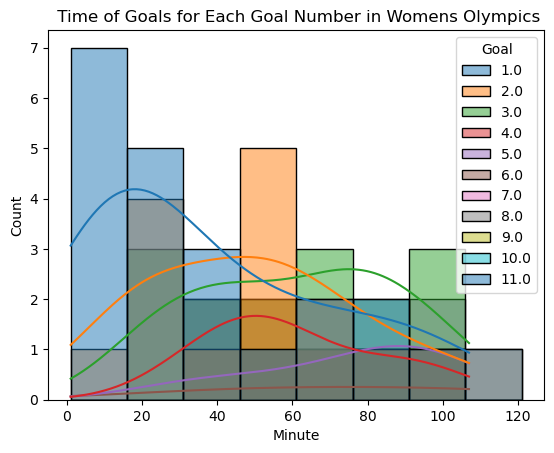

In [187]:
ax=sns.histplot(data=df, x='Minute', kde=True, hue='Goal', binwidth=15, palette='tab10')
ax.set_title(' Time of Goals for Each Goal Number in Womens Olympics');

In [139]:
goal_num = df['Goal'].unique()

np.delete(goal_num, 5)


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [147]:
goal_num = np.delete(goal_num, 5)

In [148]:
goal_num

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

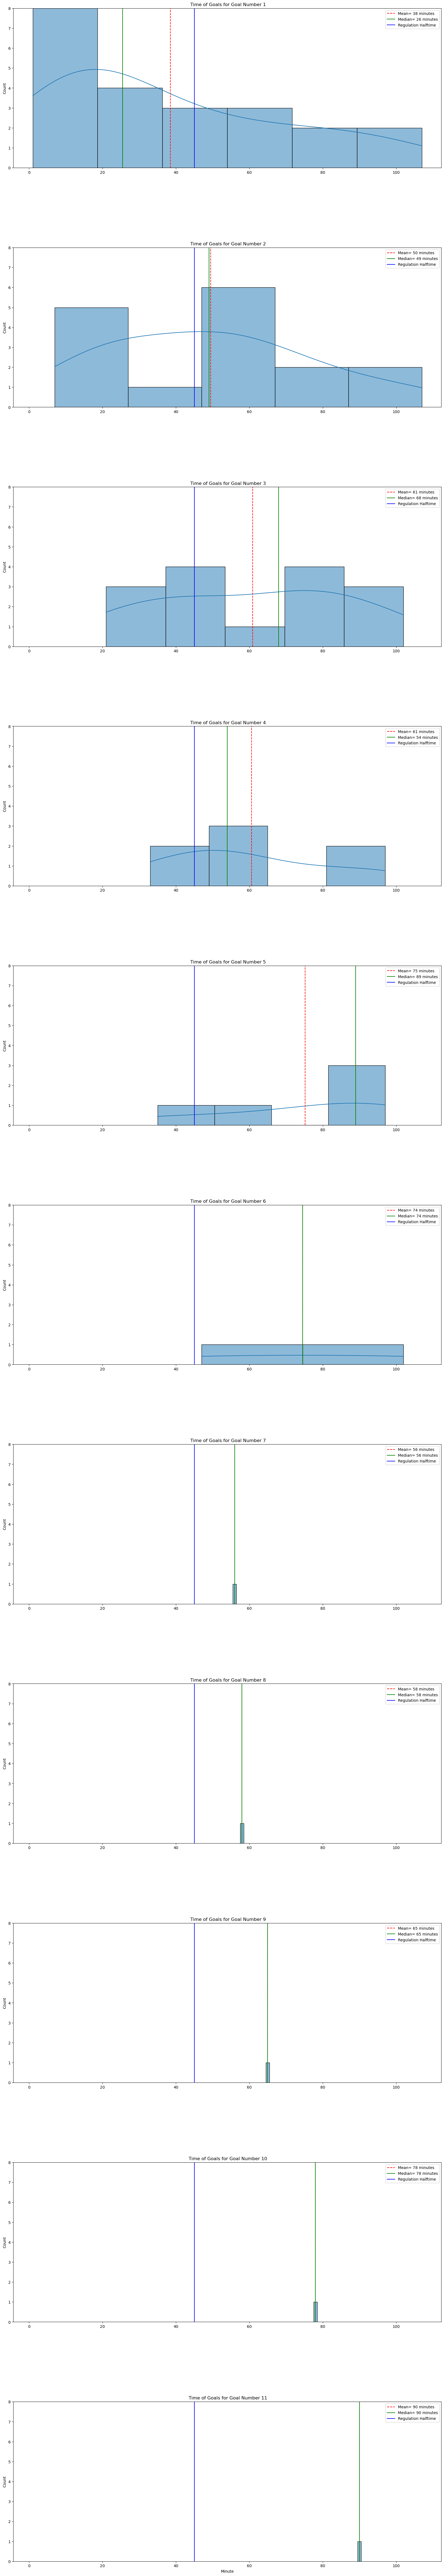

In [162]:
fig, ax = plt.subplots(11, 1, figsize = (20, 120), sharex=True)
plt.subplots_adjust(hspace=0.5)
for goal in goal_num:
    plt.sca(ax[goal-1])
    
    sns.histplot(data=df[df['Goal']==goal], x=df[df['Goal']==goal]['Minute'], kde=True)
    ax[goal-1].set_title(' Time of Goals for Goal Number ' + str(goal))
    ax[goal-1].axvline(df[df['Goal']==goal]['Minute'].mean(), color='r', linestyle='--', 
                       label='Mean= {} minutes'.format(round(df[df['Goal']==goal]['Minute'].mean())))
    ax[goal-1].axvline(df[df['Goal']==goal]['Minute'].median(), color='g', linestyle='-', 
                       label='Median= {} minutes'.format(round(df[df['Goal']==goal]['Minute'].median())))
    ax[goal-1].axvline(x=45, label='Regulation Halftime', color='b', linestyle='-')
    ax[goal-1].legend()
    ax[goal - 1].tick_params(axis='x', which='both', labelbottom=True)
    ax[goal - 1].set_ylim(0, 8)
    ax[goal - 1].set_yticks(range(0, 9))
    ;

In [164]:
average_duration = df.groupby('Country')['Duration'].mean().reset_index()

average_duration.columns = ['Country', 'Average Duration']

posx and posy should be finite values
posx and posy should be finite values


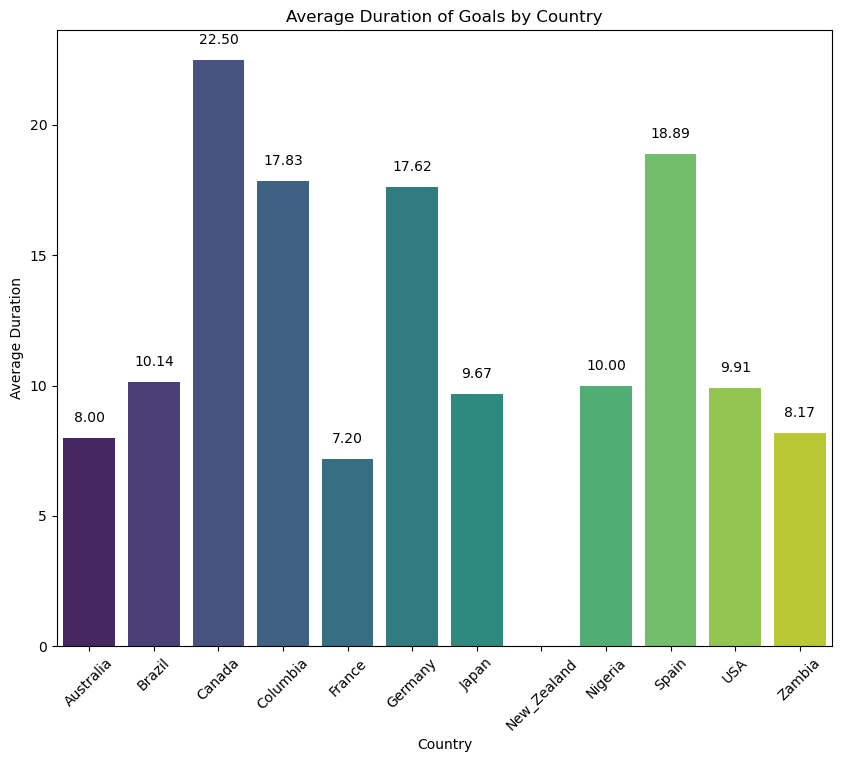

In [171]:
plt.figure(figsize=(10, 8))
bar_plot = sns.barplot(data=average_duration, x='Country', y='Average Duration', palette='viridis')

# Annotate each bar with the average duration
for index, row in average_duration.iterrows():
    bar_plot.text(index, row['Average Duration'] + 0.5,  # +0.5 for spacing above the bar
                  f'{row["Average Duration"]:.2f}',  # Format the text
                  ha='center', va='bottom')

plt.title('Average Duration of Goals by Country')
plt.xlabel('Country')
plt.ylabel('Average Duration')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

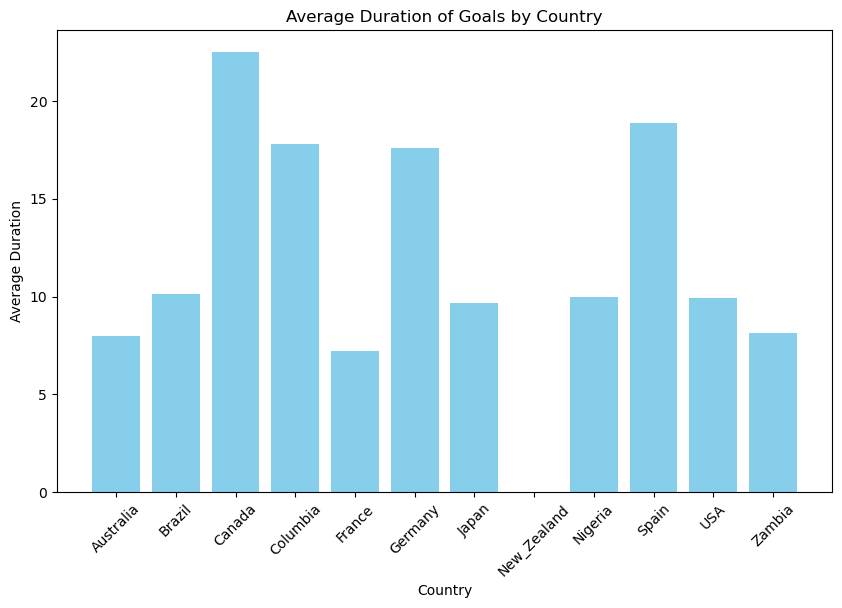

In [166]:
plt.figure(figsize=(10, 6))
plt.bar(average_duration['Country'], average_duration['Average Duration'], color='skyblue')
plt.title('Average Duration of Goals by Country')
plt.xlabel('Country')
plt.ylabel('Average Duration')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [172]:
goal_counts = df.groupby(['Country', 'Goal']).size().reset_index(name='Count')

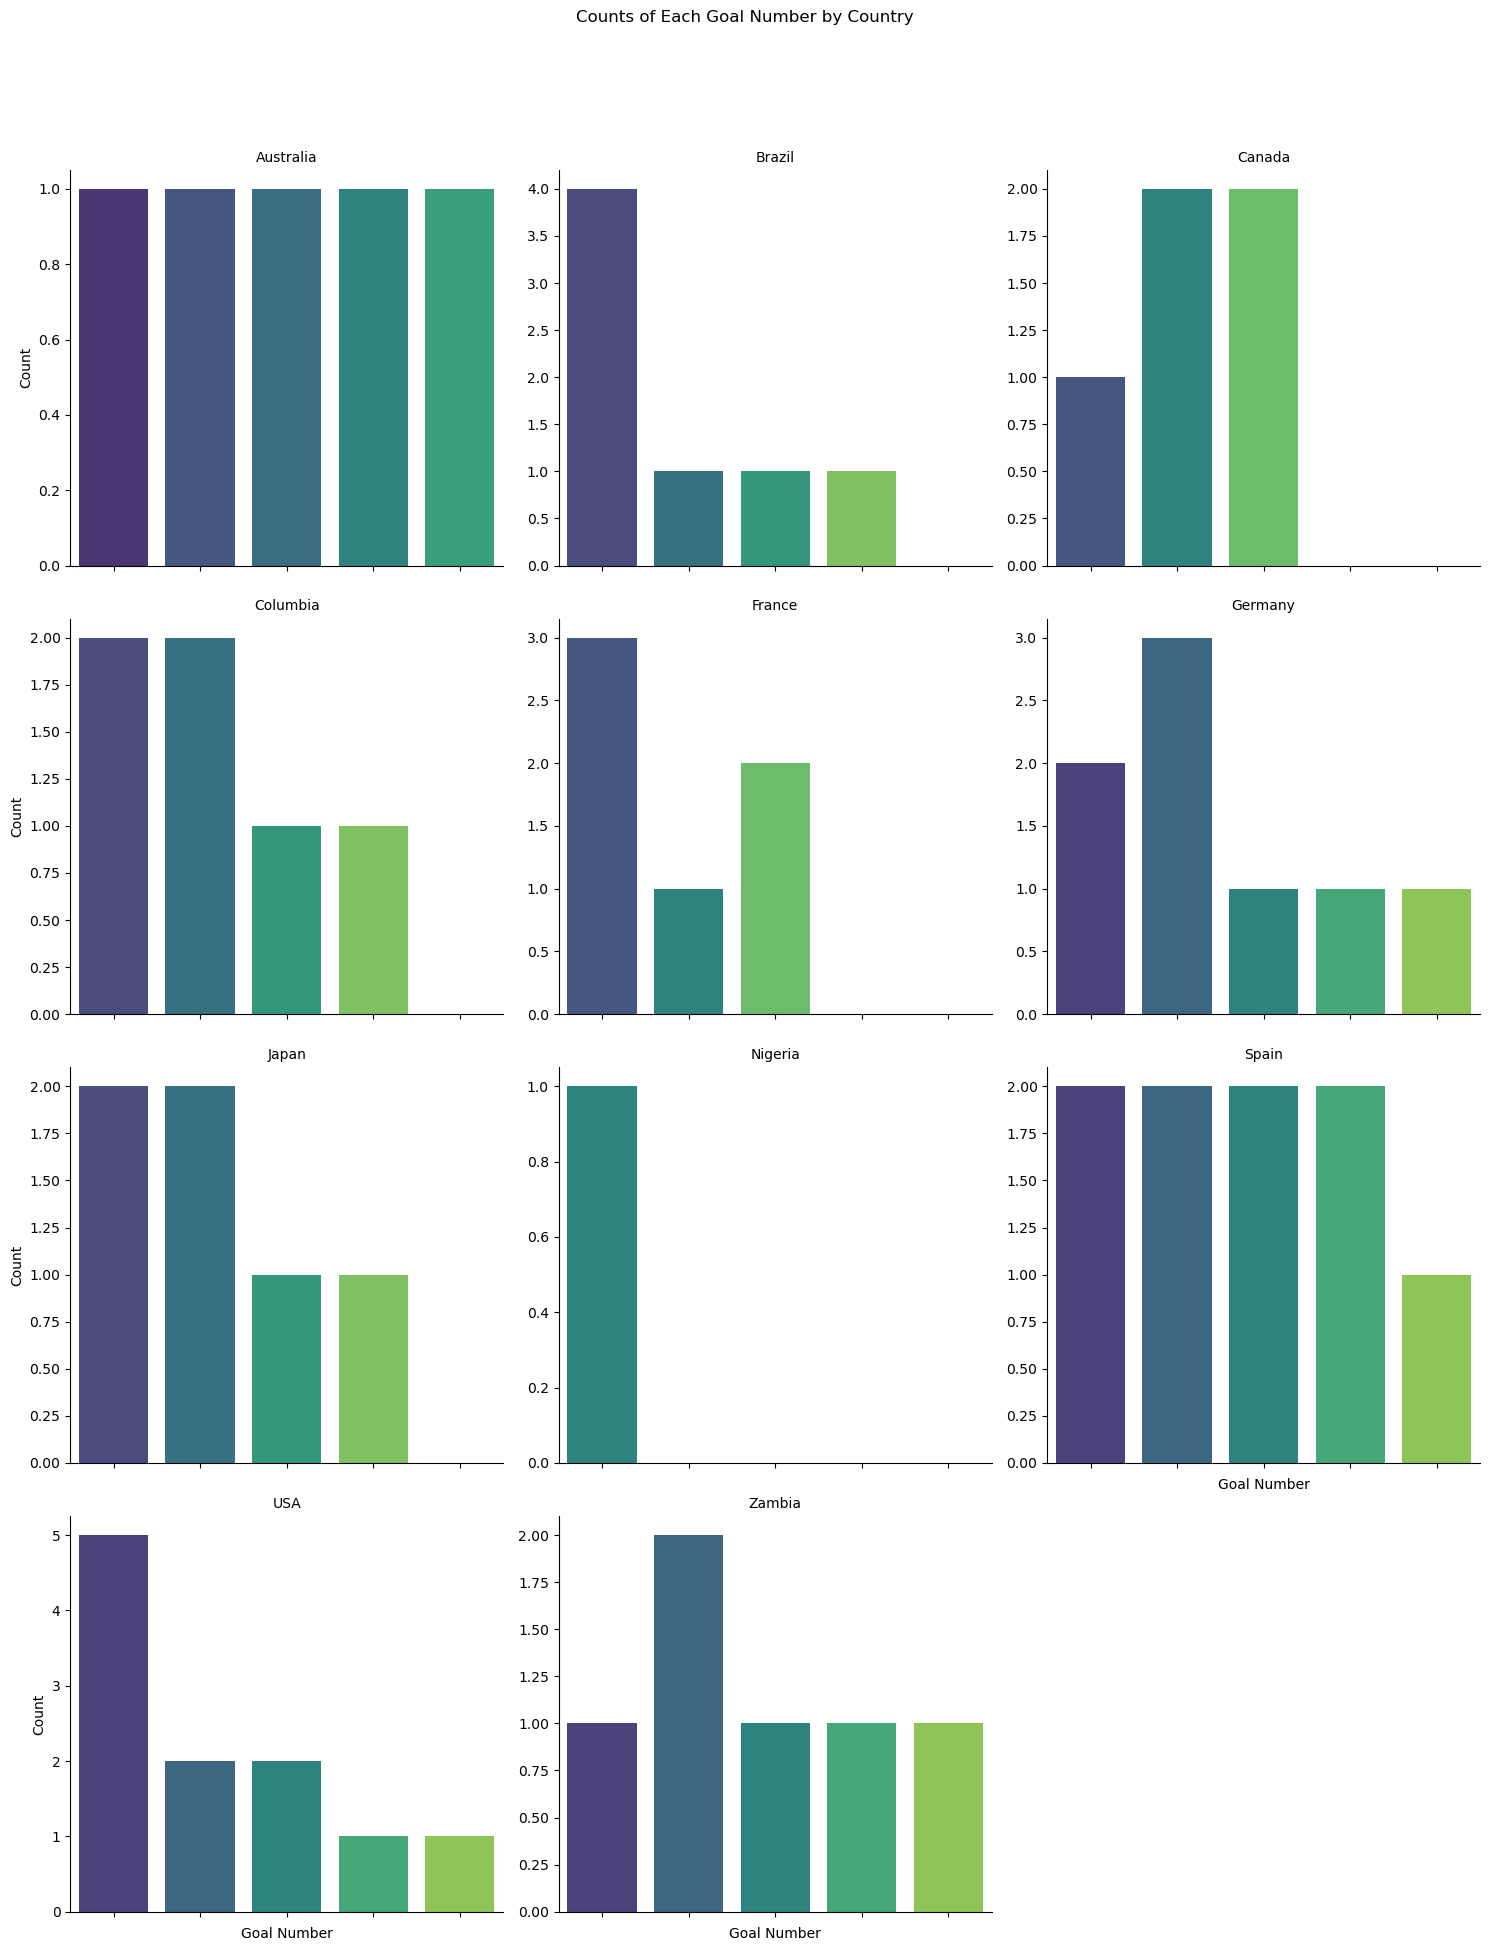

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a facet grid for plotting
g = sns.FacetGrid(goal_counts, col='Country', col_wrap=3, height=5, sharey=False)

# Map the data to a bar plot
g.map_dataframe(sns.barplot, x='Goal', y='Count', palette='viridis')

# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Goal Number", "Count")
g.set_xticklabels(rotation=45)

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Counts of Each Goal Number by Country')
plt.show()

In [174]:
pivot_table = goal_counts.pivot_table(index='Goal', columns='Country', values='Count', fill_value=0)

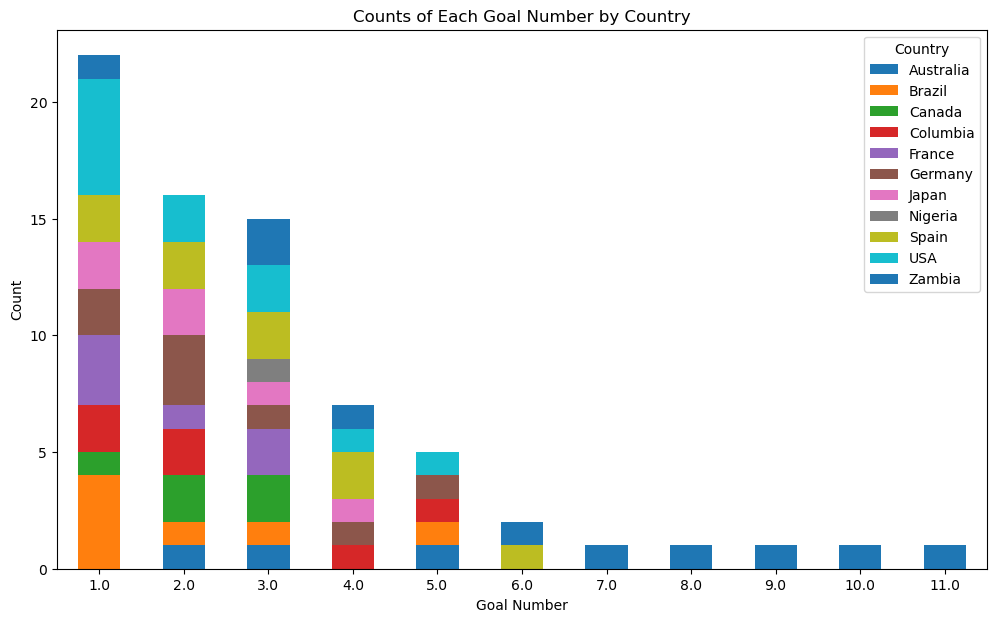

In [175]:
import matplotlib.pyplot as plt

# Create the stacked bar chart
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 7))

# Add labels and title
plt.title('Counts of Each Goal Number by Country')
plt.xlabel('Goal Number')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.legend(title='Country')

plt.show()

In [179]:
final_df = df[df['Country'].isin(['Brazil', 'USA'])]

In [180]:
final_goal_counts = final_df.groupby(['Country', 'Goal']).size().reset_index(name='Count')

# Pivot the DataFrame to get a matrix with Goal numbers as rows and Countries as columns
final_pivot_table = final_goal_counts.pivot_table(index='Goal', columns='Country', values='Count', fill_value=0)


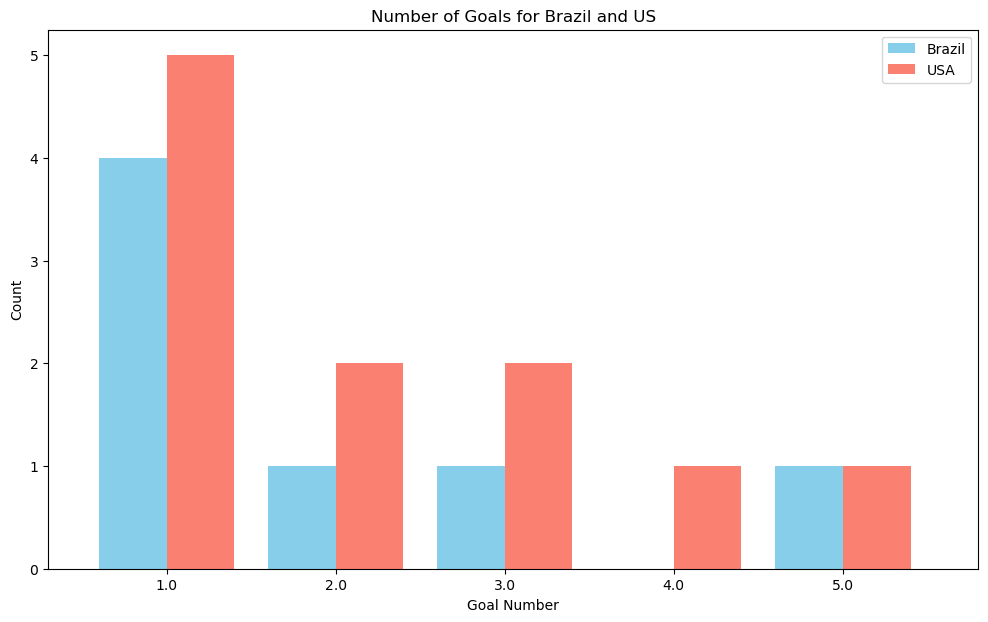

In [186]:
import matplotlib.pyplot as plt
import numpy as np

# Create side-by-side bar charts
fig, ax = plt.subplots(figsize=(12, 7))

# Define the width of the bars and the positions of the bars
width = 0.4
goal_numbers = pivot_table.index
brazil_counts = pivot_table['Brazil']
us_counts = pivot_table['USA']

# Define positions for the bars
positions_brazil = np.arange(len(goal_numbers))
positions_us = positions_brazil + width

# Plot the bars
ax.bar(positions_brazil, brazil_counts, width, label='Brazil', color='skyblue')
ax.bar(positions_us, us_counts, width, label='USA', color='salmon')

# Add labels and title
ax.set_title('Number of Goals for Brazil and US')
ax.set_xlabel('Goal Number')
ax.set_ylabel('Count')
ax.set_xticks(positions_brazil + width / 2)
ax.set_xticklabels(goal_numbers)
ax.legend()
ax.set_xlim(-.5, 5)
plt.show()